In [4]:
import torch
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
import numpy as np
import pandas as pd

In [5]:
col=  "UT (hour) for each column"
row = "Altitudes (km) for each row"

mat_list = ["Na Density (cm^(-3))",

"Na Density Error (cm^(-3))",

"Temperature (K)",

"Temperature Error (K)",

"Vertical Wind (m/s)",

"Vertical Wind Error (m/s)",

"Zonal Wind (m/s)",

"Zonal Wind Error (m/s)",

"Meridional Wind (m/s)",

"Meridional Wind Error (m/s)"]


mat_flag = False
col_flag = False
row_flag = False
col_np = []
row_np = []
mat_np = {}

with open('/Users/jiahuieffiehu/Desktop/Desktop/Embry-Riddle/scripts/data/201606/20160607_15min_0.5km_60s_20_DTWUV.dat', 'r') as f:
  for line in f:
    line=line.strip()

    if line == col:
      col_flag = True
      continue
    if line == row:
      row_flag = True
      continue
    if line in mat_list:
      mat_flag = line
      continue

    if line == '':
      continue

    if col_flag:
      col_np = np.fromstring(line, dtype=float, sep=' ')
      col_flag = False
    if row_flag:
      row_np = np.fromstring(line, dtype=float, sep=' ')
      row_flag = False
    if mat_flag:
      if mat_flag in mat_np.keys():
        mat_np[mat_flag] = np.vstack([mat_np[mat_flag],np.fromstring(line, dtype=float, sep=' ')])
      else:
        mat_np[mat_flag] = np.fromstring(line, dtype=float, sep=' ')

In [6]:
for key in mat_np.keys():
  mat_np[key][mat_np[key] == -999.0] = np.nan
    
df_dict = {}
for key in mat_np.keys():
  df_dict[key] = pd.DataFrame(mat_np[key], index=row_np, columns=col_np)

In [7]:
import random

def create_missing_strips(df, num_strips, strip_width):
  modified_df = df.copy()
  num_cols = len(df.columns)

  for _ in range(num_strips):
    start_col = random.randint(0, num_cols - strip_width)
    end_col = start_col + strip_width
    modified_df.iloc[:, start_col:end_col] = np.nan

  return modified_df

num_strips = 2  
strip_width = 2 

modified_df_dict = {}
for key in df_dict.keys():
  modified_df_dict[key] = create_missing_strips(df_dict[key], num_strips, strip_width)

In [8]:
from sklearn.preprocessing import StandardScaler
key_to_modify = "Na Density (cm^(-3))"
arr = modified_df_dict[key_to_modify].to_numpy()
expanded_arr = np.expand_dims(arr, axis=-1)
X = StandardScaler().fit_transform(expanded_arr.reshape(-1, expanded_arr.shape[-1])).reshape(expanded_arr.shape)

arr_ori = df_dict[key_to_modify].to_numpy()
expanded_arr = np.expand_dims(arr_ori, axis=-1)
X_ori = StandardScaler().fit_transform(expanded_arr.reshape(-1, expanded_arr.shape[-1])).reshape(expanded_arr.shape)
dataset = {'X':X}

In [9]:
from pypots.imputation import SAITS
from pypots.utils.metrics import calc_mae
saits = SAITS(n_steps=113, n_features=1, n_layers=2, d_model=256, d_ffn=128, n_heads=4, d_k=64, d_v=64, dropout=0.01, epochs=100)
# Here I use the whole dataset as the training set because ground truth is not visible to the model, you can also split it into train/val/test sets
saits.fit(dataset)  # train the model on the dataset
imputation = saits.impute(dataset)  # impute the originally-missing values and artificially-missing values

2024-07-16 09:17:07 [INFO]: No given device, using default device: cpu
2024-07-16 09:17:07 [WARNING]: ‼️ saving_path not given. Model files and tensorboard file will not be saved.
2024-07-16 09:17:07 [INFO]: SAITS initialized with the given hyperparameters, the number of trainable parameters: 1,318,519
2024-07-16 09:17:09 [INFO]: Epoch 001 - training loss: 3.1864
2024-07-16 09:17:10 [INFO]: Epoch 002 - training loss: 1.3231
2024-07-16 09:17:11 [INFO]: Epoch 003 - training loss: 0.9767
2024-07-16 09:17:13 [INFO]: Epoch 004 - training loss: 0.7199
2024-07-16 09:17:14 [INFO]: Epoch 005 - training loss: 0.6726
2024-07-16 09:17:15 [INFO]: Epoch 006 - training loss: 0.6115
2024-07-16 09:17:16 [INFO]: Epoch 007 - training loss: 0.5812
2024-07-16 09:17:17 [INFO]: Epoch 008 - training loss: 0.5461
2024-07-16 09:17:18 [INFO]: Epoch 009 - training loss: 0.4695
2024-07-16 09:17:19 [INFO]: Epoch 010 - training loss: 0.4207
2024-07-16 09:17:21 [INFO]: Epoch 011 - training loss: 0.4059
2024-07-16 09:

NameError: name 'df_to_modify' is not defined

In [11]:
indicating_mask = np.isnan(X) ^ np.isnan(X_ori)  # indicating mask for imputation error calculation
mae = calc_mae(imputation, np.nan_to_num(X_ori), indicating_mask)  # calculate mean absolute error on the ground truth (artificially-missing values)
saits.save("save_it_here/saits_physionet2012.pypots", overwrite=True)  # save the model for future use
saits.load("save_it_here/saits_physionet2012.pypots")  # reload the serialized model file for following imputation or trainin

2024-07-16 09:20:38 [WARNING]: ‼️ File save_it_here/saits_physionet2012.pypots exists. Argument `overwrite` is True. Overwriting now...
2024-07-16 09:20:38 [INFO]: Saved the model to save_it_here/saits_physionet2012.pypots
2024-07-16 09:20:38 [INFO]: Model loaded successfully from save_it_here/saits_physionet2012.pypots


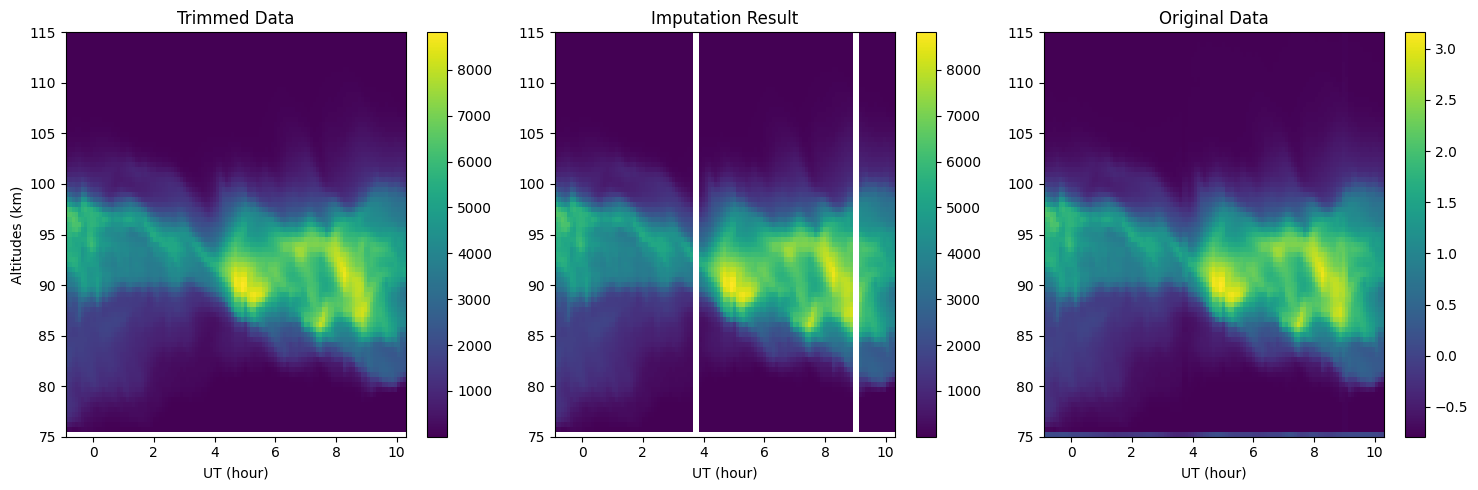

In [23]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(1, 3, figsize=(15, 5))  # 1 row, 3 columns

key_to_plot = 'Na Density (cm^(-3))'

im1 = axes[0].imshow(df_dict[key_to_plot], aspect='auto', origin='lower', cmap='viridis',
                     extent=[col_np.min(), col_np.max(), row_np.min(), row_np.max()])
axes[0].set_xlabel('UT (hour)')
axes[0].set_ylabel('Altitudes (km)')
axes[0].set_title('Trimmed Data')
fig.colorbar(im1, ax=axes[0])

im2 = axes[1].imshow(modified_df_dict[key_to_plot], aspect='auto', origin='lower', cmap='viridis',
                     extent=[col_np.min(), col_np.max(), row_np.min(), row_np.max()])
axes[1].set_xlabel('UT (hour)')
axes[1].set_title('Imputation Result')
fig.colorbar(im2, ax=axes[1])

im3 = axes[2].imshow(imputation, aspect='auto', origin='lower', cmap='viridis',
                     extent=[col_np.min(), col_np.max(), row_np.min(), row_np.max()])
axes[2].set_xlabel('UT (hour)')
axes[2].set_title('Original Data')
fig.colorbar(im3, ax=axes[2])

plt.tight_layout() 
plt.show()

